In [1]:
import sys
import numpy as np
import xarray as xr
from scipy.io import loadmat
from datetime import datetime
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib as mpl
sys.path.append('/Users/jakesteinberg/ECCOv4-py/ECCOv4-py')
import ecco_v4_py as ecco
%matplotlib inline

In [2]:
# -- ECCO GRIDS -- 
# base_dir = '/home/username/'
base_dir = '/Users/jakesteinberg/Documents/NASA_OSTST/ECCO/'
## define a high-level directory for ECCO fields
ECCO_dir = base_dir + '/v5'
## Load the model grid
grid_dir= ECCO_dir + '/nctiles_grid/'
# ecco_grid = ecco.load_ecco_grid_nc(grid_dir, 'ECCOv4r3_grid.nc', k_subset=[0])
ecco_grid = ecco.load_ecco_grid_nc(grid_dir, 'ECCO-GRID.nc')
data_dir= ECCO_dir + '/nctiles_monthly'  
ecco_daily_vars = ecco.recursive_load_ecco_var_from_years_nc(data_dir,vars_to_load=['PHIBOT'],\
                                           years_to_load=range(2008,2018)).load()    
## Merge the ecco_grid with the ecco_vars to make the ecco_ds
ecco_monthly_ds = xr.merge((ecco_grid , ecco_daily_vars))

# bathymetry
tile_num=10
lon_range = [-98, -78]; lat_range = [17, 31] 
lons = ecco_grid.XC.sel(tile=tile_num)
lats = ecco_grid.YC.sel(tile=tile_num)
dep = ecco_grid.Depth
dep = dep.where(ecco_grid.hFacC.isel(tile=tile_num,k=0) !=0, np.nan).isel(tile=tile_num)

loading files of  PHIBOT


In [26]:
np.shape(dep)

(270, 270)

In [3]:
# obs 2002-2021
grace = xr.open_dataset('/Users/jakesteinberg/Documents/NASA_OSTST/GRACE/GRCTellus.JPL.200204_202201.GLO.RL06M.MSCNv02CRI.nc')

In [4]:
mascon = xr.open_dataset('/Users/jakesteinberg/Documents/NASA_OSTST/GRACE/JPL_MSCNv02_PLACEMENT.nc')

(-100.0, -50.0)

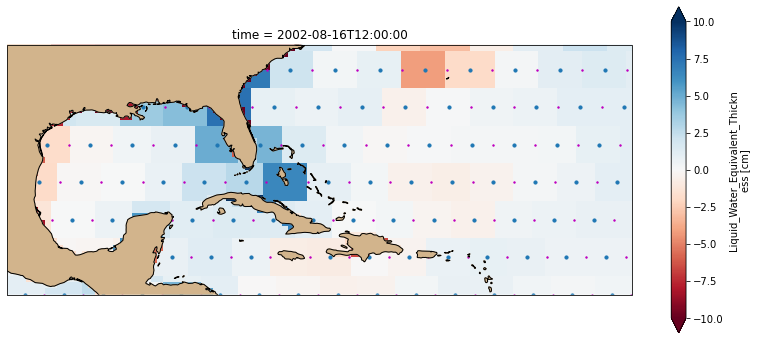

In [5]:
m_lon = mascon.mascon_lon
m_lat = mascon.mascon_lat
m_lon_e1 = np.diff(m_lon)/2 + m_lon[0:-1]
m_lat_e1 = np.diff(m_lat)/2 + m_lat[0:-1]
# m_lat_e1 = m_lat[0:-1]

f, ax = plt.subplots(1,1,figsize=(14,6), subplot_kw={'projection':ccrs.PlateCarree(central_longitude=0)})
this_data = grace.lwe_thickness[2]
this_data.plot(ax=ax,transform=ccrs.PlateCarree(), vmin=-10, vmax=10, cmap=plt.get_cmap('RdBu'))
ax.scatter(mascon.mascon_lon,mascon.mascon_lat,s=10,transform=ccrs.PlateCarree())
ax.scatter(m_lon_e1, m_lat_e1, s=2,transform=ccrs.PlateCarree(),color='m')
ax.add_feature(cartopy.feature.LAND, color='#D2B48C',zorder=1); ax.coastlines()
ax.set_ylim([15,35]); ax.set_xlim([-100,-50])

In [6]:
lon_in = np.where((grace.lon > 260) & (grace.lon < 280))[0]
lat_in = np.where((grace.lat > 20) & (grace.lat < 30))[0]

In [7]:
latis = [5,12,5,12,5,12]
lonis = [11,11,20,20,26,26]
gommean = grace.lwe_thickness[:,lat_in[latis],lon_in[lonis]].mean(dim=['lat','lon'])
gom_a = gommean - gommean.mean(dim='time')
gbp_a = gom_a.polyfit(dim='time', deg=1)
gbp_a_trend = xr.polyval(gom_a['time'], gbp_a.polyfit_coefficients)
gbp_a_detrend = gom_a - gbp_a_trend

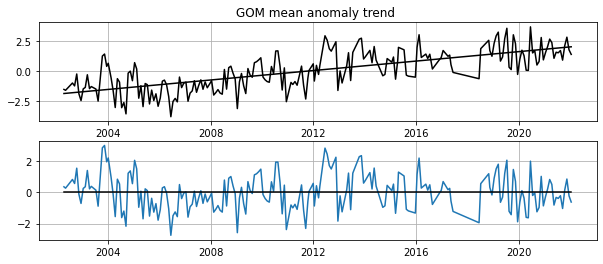

In [8]:
loni = 20; lati = 5; loni_2 = 20; lati_2 = 12; loni_3 = 11; lati_3 = 5;
loni_4 = 11; lati_4 = 12; loni_5 = 26; lati_5 = 5; loni_6 = 26; lati_6 = 12;
f, (ax,ax2) = plt.subplots(2,1,figsize=(10,4))
# ax.plot(grace.time,grace.lwe_thickness[:,lat_in[lati],lon_in[loni]])
# ax.plot(grace.time,grace.lwe_thickness[:,lat_in[lati_2],lon_in[loni_2]])
# ax.plot(grace.time,grace.lwe_thickness[:,lat_in[lati_3],lon_in[loni_3]])
# ax.plot(grace.time,grace.lwe_thickness[:,lat_in[lati_4],lon_in[loni_4]])
# ax.plot(grace.time,grace.lwe_thickness[:,lat_in[lati_5],lon_in[loni_5]])
# ax.plot(grace.time,grace.lwe_thickness[:,lat_in[lati_6],lon_in[loni_6]])
ax.plot(grace.time,gom_a,color='k')
ax.plot(grace.time,gbp_a_trend,color='k')
# ax.set_title(str(grace.lon[lon_in[loni]].data) + 'E, ' + str(grace.lat[lat_in[lati]].data) + 'N')
ax.set_title('GOM mean trend')
ax.grid()

ax2.plot(grace.time,gbp_a_detrend)
gbp_ad_trend = gbp_a_detrend.polyfit(dim='time', deg=1)
gbp_ad_trend = xr.polyval(gbp_a_detrend['time'], gbp_ad_trend.polyfit_coefficients)
ax2.plot(grace.time,gbp_ad_trend,color='k')
ax.set_title('GOM mean anomaly trend ')
ax2.grid()
# f.savefig('/Users/jakesteinberg/Documents/NASA_OSTST/meetings/2022_04_20/GOM_grace_trend.jpg', dpi=250)

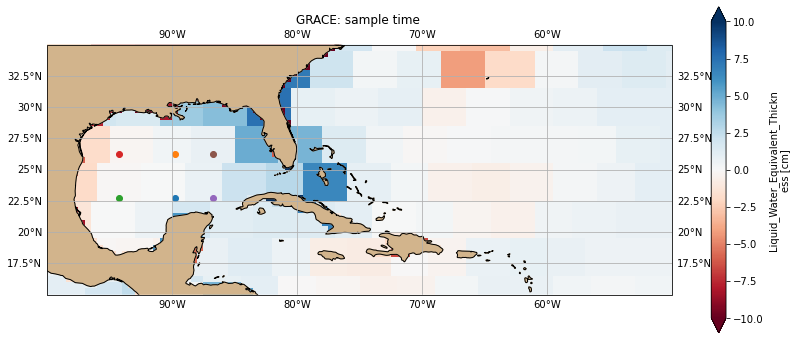

In [92]:
f, ax = plt.subplots(1,1,figsize=(14,6), subplot_kw={'projection':ccrs.PlateCarree(central_longitude=0)})
tests = grace.lwe_thickness[2]
tests.plot(ax=ax,transform=ccrs.PlateCarree(), vmin=-10, vmax=10, cmap=plt.get_cmap('RdBu'))
ax.scatter(grace.lon[lon_in[loni]], grace.lat[lat_in[lati]],transform=ccrs.PlateCarree())
ax.scatter(grace.lon[lon_in[loni_2]], grace.lat[lat_in[lati_2]],transform=ccrs.PlateCarree())
ax.scatter(grace.lon[lon_in[loni_3]], grace.lat[lat_in[lati_3]],transform=ccrs.PlateCarree())
ax.scatter(grace.lon[lon_in[loni_4]], grace.lat[lat_in[lati_4]],transform=ccrs.PlateCarree())
ax.scatter(grace.lon[lon_in[loni_5]], grace.lat[lat_in[lati_5]],transform=ccrs.PlateCarree())
ax.scatter(grace.lon[lon_in[loni_6]], grace.lat[lat_in[lati_6]],transform=ccrs.PlateCarree())
ax.add_feature(cartopy.feature.LAND, color='#D2B48C',zorder=1); ax.coastlines()
ax.set_title('GRACE: sample time ')
gl = ax.gridlines(draw_labels=True); 
ax.set_ylim([15,35]); ax.set_xlim([-100,-50])
# f.savefig('/Users/jakesteinberg/Documents/NASA_OSTST/meetings/2022_04_20/GOM_grace_map.jpg', dpi=250)

In [9]:
gobp = grace.lwe_thickness.sel(time=slice("2010-01-01", "2017-12-31"))/100
gobp = gobp - gobp.mean(dim='time')        
pgobp = gobp.polyfit(dim='time', deg=1)
gobp_trend = pgobp.polyfit_coefficients.isel(degree=0)*1e9*60*60*24*365 

gobp2 = grace.lwe_thickness.sel(time=slice("2010-01-01", "2019-12-31"))/100
pgobp2 = gobp2.polyfit(dim='time', deg=1)
gobp2_trend = pgobp2.polyfit_coefficients.isel(degree=0)*1e9*60*60*24*365

/Users/jakesteinberg/anaconda3/envs/ECCOv4_py/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
/Users/jakesteinberg/anaconda3/envs/ECCOv4_py/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/var/folders/g_/xh2hxbd10wl4stb5spmwldj00000gn/T/ipykernel_10386/3587479249.py:21: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


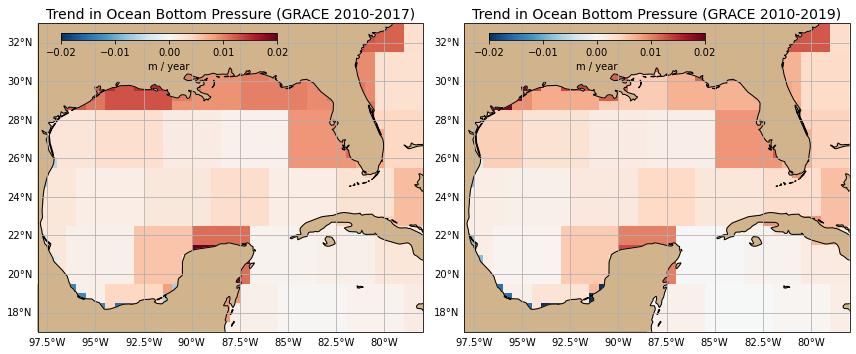

In [10]:
lon_w = -98; lon_e = -78; 
lat_s = 17; lat_n = 33; 
f, (ax,ax2) = plt.subplots(1,2,figsize=(12,5), subplot_kw={'projection':ccrs.PlateCarree(central_longitude=0)})
cc = gobp_trend.plot(ax=ax,transform=ccrs.PlateCarree(), vmin=-0.02, vmax=0.02, cmap=plt.get_cmap('RdBu_r'),add_colorbar=False)
ax.set_title('Trend in Ocean Bottom Pressure (GRACE 2010-2017)',fontsize=14)
ax.add_feature(cartopy.feature.LAND, color='#D2B48C',zorder=1); ax.coastlines()
gl = ax.gridlines(draw_labels=True); gl.ylabels_right = False; gl.xlabels_top = False;
ax.set_xlim([lon_w, lon_e]); ax.set_ylim([lat_s, lat_n])

cc = gobp2_trend.plot(ax=ax2,transform=ccrs.PlateCarree(), vmin=-0.02, vmax=0.02, cmap=plt.get_cmap('RdBu_r'),add_colorbar=False)
ax2.set_title('Trend in Ocean Bottom Pressure (GRACE 2010-2019)',fontsize=14)
ax2.add_feature(cartopy.feature.LAND, color='#D2B48C',zorder=1); ax2.coastlines()
gl = ax2.gridlines(draw_labels=True); gl.ylabels_right = False; gl.xlabels_top = False;
ax2.set_xlim([lon_w, lon_e]); ax2.set_ylim([lat_s, lat_n])

cbpos = [0.075, 0.88, 0.25, 0.02]; cax = f.add_axes(cbpos); 
cb = f.colorbar(cc, cax=cax, orientation='horizontal', label='m / year')
cbpos = [0.57, 0.88, 0.25, 0.02]; cax = f.add_axes(cbpos); 
cb = f.colorbar(cc, cax=cax, orientation='horizontal', label='m / year')
ax.grid()
plt.tight_layout()
# f.savefig('/Users/jakesteinberg/Documents/NASA_OSTST/manuscript/figures/grace_obp_trend.jpg', dpi=250)

In [21]:
lat_in = np.where((grace.lat < 31) & (grace.lat >18))[0]
lon_in = np.where((grace.lon > (360-97.5)) & (grace.lon < (360-81)))[0]
gobp_trend_sub = gobp_trend[lat_in,lon_in]
gobp2_trend_sub = gobp2_trend[lat_in,lon_in]
gobp2_timeseries_sub = gobp2[:,lat_in][:,:,lon_in]

In [12]:
gulf_mask = xr.open_dataset('/Users/jakesteinberg/Documents/NASA_OSTST/ecco_gulf_mask_3.nc')

In [44]:
mask_lon = gulf_mask.lon.data + 360
mask_lat = gulf_mask.lat.data 
mask_val = np.nan*np.ones(np.shape(gobp_trend_sub))
mask_dep = np.nan*np.ones(np.shape(gobp_trend_sub))
for i in range(np.shape(gobp_trend_sub)[0]):
    for j in range(np.shape(gobp_trend_sub)[1]):
        this_lon = gobp_trend_sub.lon[j].data
        this_lat = gobp_trend_sub.lat[i].data
        mask_lon_in = np.where((mask_lon > (this_lon-0.4)) & (mask_lon < (this_lon+0.4)))[0][0]
        mask_lat_in = np.where((mask_lat > (this_lat-0.4)) & (mask_lat < (this_lat+0.4)))[0][0]
        # print(gulf_mask.__xarray_dataarray_variable__[mask_lat_in,mask_lon_in].data)
        mask_val[i,j] = gulf_mask.__xarray_dataarray_variable__[mask_lat_in,mask_lon_in].data
        # if gulf_mask.__xarray_dataarray_variable__[mask_lat_in,mask_lon_in].data > 0:
        #     print('1')
        
        mask_in = np.where((lons.data+360 > (this_lon-0.15)) & (lons.data+360 < (this_lon+0.15)) & \
                           (lats.data > (this_lat-0.15)) & (lats.data < (this_lat+0.15)))
        mask_dep[i,j] = np.nanmean(dep[mask_in].data)

/var/folders/g_/xh2hxbd10wl4stb5spmwldj00000gn/T/ipykernel_10386/3719208567.py:18: RuntimeWarning: Mean of empty slice
  mask_dep[i,j] = np.nanmean(dep[mask_in].data)


(17.0, 33.0)

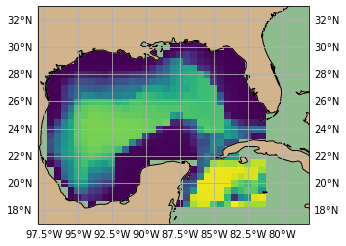

In [45]:
# PLOT mask 
f, ax = plt.subplots(1,1,figsize=(6,4), subplot_kw={'projection':ccrs.PlateCarree(central_longitude=0)})
ax.pcolor(gobp_trend_sub.lon, gobp_trend_sub.lat, mask_dep, transform=ccrs.PlateCarree()); ax.grid(); 
ax.add_feature(cartopy.feature.LAND, color='#D2B48C',zorder=1); ax.coastlines()
gl = ax.gridlines(draw_labels=True); gl.xlabels_top = False;
ax.set_facecolor('#8FBC8F'); ax.set_xlim([lon_w, lon_e]); ax.set_ylim([lat_s, lat_n])

In [77]:
gobp_ts_sub_mask = gobp2_timeseries_sub*mask_val - (gobp2_timeseries_sub*mask_val).mean(dim=['lat','lon'])

(-0.15, 0.15)

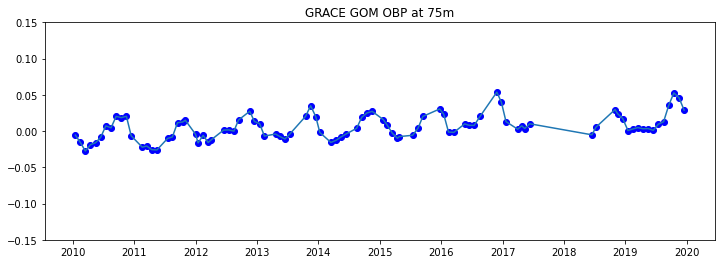

In [81]:
depth_i = 75
desired_dep = np.where((mask_dep <= depth_i) & (mask_dep > 0))
obp_d_i = np.nan*np.ones(len(gobp2.time))
f, ax = plt.subplots(1,1,figsize=(12,4))
for i in range(len(gobp2.time)):
    this_obp = []
    for j in range(len(desired_dep[0])):
        this_obp.append(gobp_ts_sub_mask[i,desired_dep[0][j],desired_dep[1][j]])
    obp_d_i[i] = np.nanmean(this_obp)
ax.plot(gobp2.time,obp_d_i)
ax.scatter(gobp2.time,obp_d_i,color='b')
ax.set_title('GRACE GOM OBP at ' + str(depth_i) + 'm')
ax.set_ylim([-0.15,0.15])

/var/folders/g_/xh2hxbd10wl4stb5spmwldj00000gn/T/ipykernel_10386/2394619980.py:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


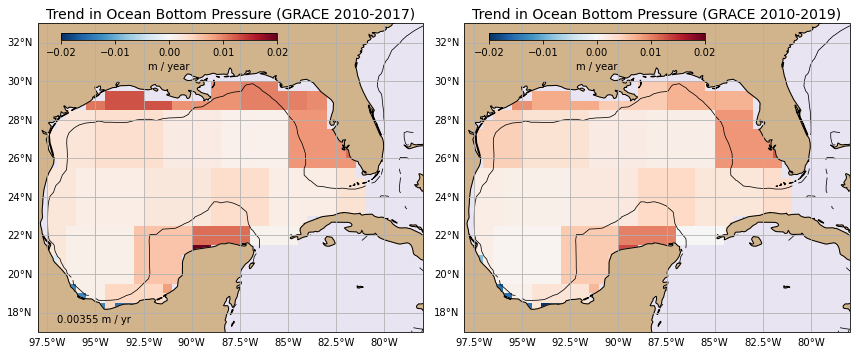

In [15]:
lon_w = -98; lon_e = -78; 
lat_s = 17; lat_n = 33; 
gobp_trend_sub_mask = gobp_trend_sub*mask_val
f, (ax,ax2) = plt.subplots(1,2,figsize=(12,5), subplot_kw={'projection':ccrs.PlateCarree(central_longitude=0)})
cc = gobp_trend_sub_mask.plot(ax=ax,transform=ccrs.PlateCarree(), vmin=-0.02, vmax=0.02, cmap=plt.get_cmap('RdBu_r'),add_colorbar=False)
ax.contour(lons,lats,dep,levels=[150],colors='k',transform=ccrs.PlateCarree(),linewidths=0.75)
ax.text(-97,17.5,str(np.round(np.nanmean(gobp_trend_sub_mask),5)) + ' m / yr')
ax.set_title('Trend in Ocean Bottom Pressure (GRACE 2010-2017)',fontsize=14)
ax.add_feature(cartopy.feature.LAND, color='#D2B48C',zorder=1); ax.coastlines()
gl = ax.gridlines(draw_labels=True); gl.ylabels_right = False; gl.xlabels_top = False;
ax.set_xlim([lon_w, lon_e]); ax.set_ylim([lat_s, lat_n])
ax.set_facecolor('#e8e4f2');

gobp2_trend_sub_mask = gobp2_trend_sub*mask_val
cc = gobp2_trend_sub_mask.plot(ax=ax2,transform=ccrs.PlateCarree(), vmin=-0.02, vmax=0.02, cmap=plt.get_cmap('RdBu_r'),add_colorbar=False)
ax2.contour(lons,lats,dep,levels=[150],colors='k',transform=ccrs.PlateCarree(),linewidths=0.75)
ax2.set_title('Trend in Ocean Bottom Pressure (GRACE 2010-2019)',fontsize=14)
ax2.add_feature(cartopy.feature.LAND, color='#D2B48C',zorder=1); ax2.coastlines()
gl = ax2.gridlines(draw_labels=True); gl.ylabels_right = False; gl.xlabels_top = False;
ax2.set_xlim([lon_w, lon_e]); ax2.set_ylim([lat_s, lat_n])
ax2.set_facecolor('#e8e4f2');

cbpos = [0.075, 0.88, 0.25, 0.02]; cax = f.add_axes(cbpos); 
cb = f.colorbar(cc, cax=cax, orientation='horizontal', label='m / year')
cbpos = [0.57, 0.88, 0.25, 0.02]; cax = f.add_axes(cbpos); 
cb = f.colorbar(cc, cax=cax, orientation='horizontal', label='m / year')
ax.grid()
plt.tight_layout()
# f.savefig('/Users/jakesteinberg/Documents/NASA_OSTST/meetings/2022_06_23/grace_obp_trend.jpg', dpi=250)

In [73]:
np.nanmean(gobp_trend_sub_mask)

0.0035468323202283232

In [18]:
gobp2_trend_sub_mask[:,0].data

array([        nan,         nan,         nan,         nan,         nan,
       -0.00855911,  0.00153552,  0.00153552,  0.00153552,  0.00146044,
        0.00146044,  0.00146044,  0.00146044,  0.00146044,  0.00146044,
               nan,  0.00471261,  0.00471261,  0.00471261,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan])